# Similarity Search with Transformers + RAG
implementing a similarity search using:

- Mocked text data
- Hugging Face transformers for embeddings
- Pandas for data management
- Cosine similarity for ranking results
- LLM Prompt Engineering


#### 1. Setup and Imports
First, let's import the necessary libraries:

In [15]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Dict, Tuple

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

#### 2. Define Embedding Function
This function will convert text to vector embeddings using the transformer model:

In [16]:
def get_embedding(text, tokenizer, model):
    """
    Convert text to embeddings using a transformer model.

    Args:
        text (str): Input text
        tokenizer: Hugging Face tokenizer
        model: Hugging Face model

    Returns:
        np.ndarray: The embedding vector
    """
    # Tokenize the text and convert to tensor
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)

    # Use mean pooling to get a single vector representation
    attention_mask = inputs['attention_mask']
    token_embeddings = outputs.last_hidden_state

    # Calculate mean of token embeddings weighted by attention mask
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    embeddings = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    return embeddings.numpy()

#### 3. Create Mock Data
Now let's generate some mock text data for our similarity search:

In [17]:
def create_mock_data(num_documents=20):
    """
    Create mock text data for similarity search.

    Args:
        num_documents (int): Number of documents to create

    Returns:
        pd.DataFrame: DataFrame with documents and metadata
    """
    topics = [
        "artificial intelligence and machine learning",
        "climate change and environmental sustainability",
        "renewable energy technologies",
        "space exploration and astronomy",
        "quantum computing and physics",
        "biotechnology and genetic engineering",
        "cryptocurrency and blockchain technology",
        "cybersecurity and data privacy"
    ]

    documents = []
    main_topics = []
    additional_topics_list = []

    for i in range(num_documents):
        # Select a random topic as the main subject
        main_topic = np.random.choice(topics)
        main_topics.append(main_topic)

        # Select 0-2 additional topics to blend in
        num_additional = np.random.randint(0, 3)
        additional_topics = np.random.choice(
            [t for t in topics if t != main_topic],
            size=min(num_additional, len(topics)-1),
            replace=False
        )
        additional_topics_list.append(list(additional_topics))

        # Create a document about the topic(s)
        doc = f"This text discusses {main_topic}"
        if len(additional_topics) > 0:
            doc += f" with connections to {' and '.join(additional_topics)}"
        doc += "."

        # Add some random sentences
        sentences = [
            "The latest research in this field shows promising results.",
            "Many experts consider this area crucial for future development.",
            "Recent advances have accelerated progress significantly.",
            "This subject has gained considerable attention in recent years.",
            "There are still many unanswered questions in this domain.",
            "Interdisciplinary approaches are proving valuable in this context."
        ]

        # Add 1-3 random sentences
        for _ in range(np.random.randint(1, 4)):
            doc += " " + np.random.choice(sentences)

        documents.append(doc)

    # Create a DataFrame with documents and metadata
    documents_df = pd.DataFrame({
        "document_id": range(num_documents),
        "text": documents,
        "main_topic": main_topics,
        "additional_topics": additional_topics_list,
        "created_at": pd.Timestamp.now()
    })

    return documents_df

#### 4. Load Model and Create Documents
Load the transformer model and create our mock document collection:

In [18]:
# Load tokenizer and model
print("Loading transformer model...")
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Create mock data
print("Creating mock documents...")
documents_df = create_mock_data(num_documents=15)

# Display sample documents
print(f"\nCreated {len(documents_df)} mock documents.")
documents_df[["document_id", "text", "main_topic"]].head(3)

Loading transformer model...
Creating mock documents...

Created 15 mock documents.


,document_id,text,main_topic
0,0,This text discusses cryptocurrency and blockch...,cryptocurrency and blockchain technology
1,1,This text discusses space exploration and astr...,space exploration and astronomy
2,2,This text discusses artificial intelligence an...,artificial intelligence and machine learning


#### 5. Create Document Embeddings
Index all documents by converting them to embeddings:

In [44]:
def index_documents(documents_df, tokenizer, model):
    """
    Create embeddings for all documents in the collection.

    Args:
        documents_df (pd.DataFrame): DataFrame containing documents
        tokenizer: Hugging Face tokenizer
        model: Hugging Face model

    Returns:
        tuple: (document texts list, embeddings matrix)
    """
    documents = documents_df['text'].tolist()
    all_embeddings = []

    print(f"Indexing {len(documents)} documents...")
    for doc in documents:
        embedding = get_embedding(doc, tokenizer, model)
        all_embeddings.append(embedding[0])

    return documents, np.array(all_embeddings)

# Create embeddings for all documents
documents, embeddings = index_documents(documents_df, tokenizer, model)
print(f"Created embeddings with shape: {embeddings.shape}")
documents

Indexing 15 documents...
Created embeddings with shape: (15, 384)


['This text discusses cryptocurrency and blockchain technology. Recent advances have accelerated progress significantly. Recent advances have accelerated progress significantly. There are still many unanswered questions in this domain.',
 'This text discusses space exploration and astronomy with connections to artificial intelligence and machine learning and renewable energy technologies. This subject has gained considerable attention in recent years. There are still many unanswered questions in this domain.',
 'This text discusses artificial intelligence and machine learning with connections to renewable energy technologies. Many experts consider this area crucial for future development. This subject has gained considerable attention in recent years. This subject has gained considerable attention in recent years.',
 'This text discusses cybersecurity and data privacy with connections to artificial intelligence and machine learning and climate change and environmental sustainability. R

#### And Embeddings

In [45]:
embeddings

array([[-0.12960419,  0.07923365, -0.02694061, ..., -0.2475112 ,
         0.21094798,  0.09393626],
       [-0.10104501, -0.07355984,  0.25606272, ..., -0.04953708,
        -0.2613638 , -0.14020362],
       [-0.21012706,  0.16488267,  0.15863587, ...,  0.02854178,
        -0.15110308, -0.05248622],
       ...,
       [-0.17720748,  0.04211153, -0.24099883, ...,  0.09658027,
        -0.13010383, -0.18497162],
       [-0.13413687,  0.17052114, -0.02972368, ...,  0.02687953,
        -0.09316618,  0.0830415 ],
       [-0.39279035,  0.0569226 , -0.06339079, ..., -0.06978017,
        -0.01875225,  0.00104717]], dtype=float32)

#### 6. Implement Search Function
Now let's implement the similarity search function:

In [20]:
def search(query, documents, embeddings, documents_df, tokenizer, model, top_k=5):
    """
    Search for documents similar to the query.

    Args:
        query (str): Search query
        documents (list): List of document texts
        embeddings (np.ndarray): Matrix of document embeddings
        documents_df (pd.DataFrame): DataFrame with document metadata
        tokenizer: Hugging Face tokenizer
        model: Hugging Face model
        top_k (int): Number of top results to return

    Returns:
        pd.DataFrame: DataFrame containing search results
    """
    # Get embedding for the query
    query_embedding = get_embedding(query, tokenizer, model)

    # Calculate cosine similarity between query and all documents
    similarities = cosine_similarity(query_embedding, embeddings)[0]

    # Get indices of top_k most similar documents
    top_indices = np.argsort(similarities)[::-1][:top_k]

    # Prepare results using pandas
    results_data = []
    for idx in top_indices:
        results_data.append({
            "document_id": idx,
            "similarity": round(float(similarities[idx]), 4),
            "text": documents[idx],
            "main_topic": documents_df.loc[idx, "main_topic"],
            "additional_topics": documents_df.loc[idx, "additional_topics"]
        })

    results_df = pd.DataFrame(results_data)
    return results_df

#### 7. Search and Analyze Results
Let's perform some searches and analyze the results:

In [21]:
# Example search query
query = "artificial intelligence applications in business"
print(f"Searching for: '{query}'")

# Perform search
results_df = search(query, documents, embeddings, documents_df, tokenizer, model, top_k=3)

# Display results
print("\nSearch Results:")
display(results_df[["similarity", "text"]])

# Display topics in results
print("\nTopics in Results:")
display(results_df[["document_id", "main_topic", "additional_topics"]])

# Analyze results
print(f"\nAverage similarity score: {results_df['similarity'].mean():.4f}")
print(f"Topics covered in results: {results_df['main_topic'].unique()}")

Searching for: 'artificial intelligence applications in business'

Search Results:


,similarity,text
0,0.4528,This text discusses artificial intelligence an...
1,0.4057,This text discusses artificial intelligence an...
2,0.3165,This text discusses biotechnology and genetic ...



Topics in Results:


,document_id,main_topic,additional_topics
0,10,artificial intelligence and machine learning,[]
1,2,artificial intelligence and machine learning,[renewable energy technologies]
2,7,biotechnology and genetic engineering,[artificial intelligence and machine learning]



Average similarity score: 0.3917
Topics covered in results: [np.str_('artificial intelligence and machine learning')
 np.str_('biotechnology and genetic engineering')]


#### 8. Visualization
Let's visualize the results:

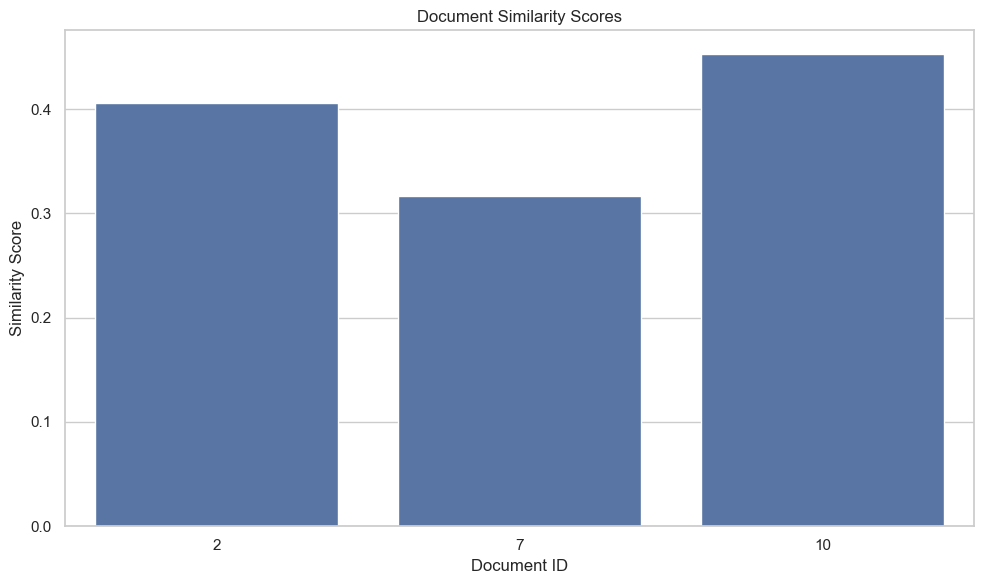

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='document_id', y='similarity', data=results_df)
plt.title('Document Similarity Scores')
plt.xlabel('Document ID')
plt.ylabel('Similarity Score')
plt.tight_layout()
plt.show()

#### 9. Try Multiple Queries
Let's try a few different search queries to see how results vary:

In [23]:
# List of queries to try
sample_queries = [
    "Tell me about artificial intelligence",
    "Why is renewable energy necessary",
    "Why is cybersecurity important?",
    "What space can you do quantum computing in?"
]

# Search for each query and display results
for query in sample_queries:
    print(f"\n\n--- Searching for: '{query}' ---")
    results_df = search(query, documents, embeddings, documents_df, tokenizer, model, top_k=3)

    print("\nTop 3 Results:")
    display(results_df[["similarity", "text"]])

    # Show topic distribution
    print("\nTopic Distribution:")
    topic_counts = results_df['main_topic'].value_counts()
    display(topic_counts)

    # Display a separator
    print("-" * 80)



--- Searching for: 'Tell me about artificial intelligence' ---

Top 3 Results:


,similarity,text
0,0.4415,This text discusses artificial intelligence an...
1,0.4123,This text discusses biotechnology and genetic ...
2,0.3850,This text discusses space exploration and astr...



Topic Distribution:


main_topic
artificial intelligence and machine learning    1
biotechnology and genetic engineering           1
space exploration and astronomy                 1
Name: count, dtype: int64

--------------------------------------------------------------------------------


--- Searching for: 'Why is renewable energy necessary' ---

Top 3 Results:


,similarity,text
0,0.5336,This text discusses renewable energy technolog...
1,0.4732,This text discusses artificial intelligence an...
2,0.2377,This text discusses space exploration and astr...



Topic Distribution:


main_topic
renewable energy technologies                   1
artificial intelligence and machine learning    1
space exploration and astronomy                 1
Name: count, dtype: int64

--------------------------------------------------------------------------------


--- Searching for: 'Why is cybersecurity important?' ---

Top 3 Results:


,similarity,text
0,0.5696,This text discusses cybersecurity and data pri...
1,0.4289,This text discusses cybersecurity and data pri...
2,0.3749,This text discusses cybersecurity and data pri...



Topic Distribution:


main_topic
cybersecurity and data privacy    3
Name: count, dtype: int64

--------------------------------------------------------------------------------


--- Searching for: 'What space can you do quantum computing in?' ---

Top 3 Results:


,similarity,text
0,0.5233,This text discusses quantum computing and phys...
1,0.5048,This text discusses quantum computing and phys...
2,0.4465,This text discusses artificial intelligence an...



Topic Distribution:


main_topic
quantum computing and physics                   2
artificial intelligence and machine learning    1
Name: count, dtype: int64

--------------------------------------------------------------------------------


#### 10. Advanced Analysis
Let's do some more advanced analysis of our document collection and search results:

Topic Distribution in Document Collection:


main_topic
artificial intelligence and machine learning       3
cybersecurity and data privacy                     3
space exploration and astronomy                    2
quantum computing and physics                      2
biotechnology and genetic engineering              2
cryptocurrency and blockchain technology           1
climate change and environmental sustainability    1
renewable energy technologies                      1
Name: count, dtype: int64

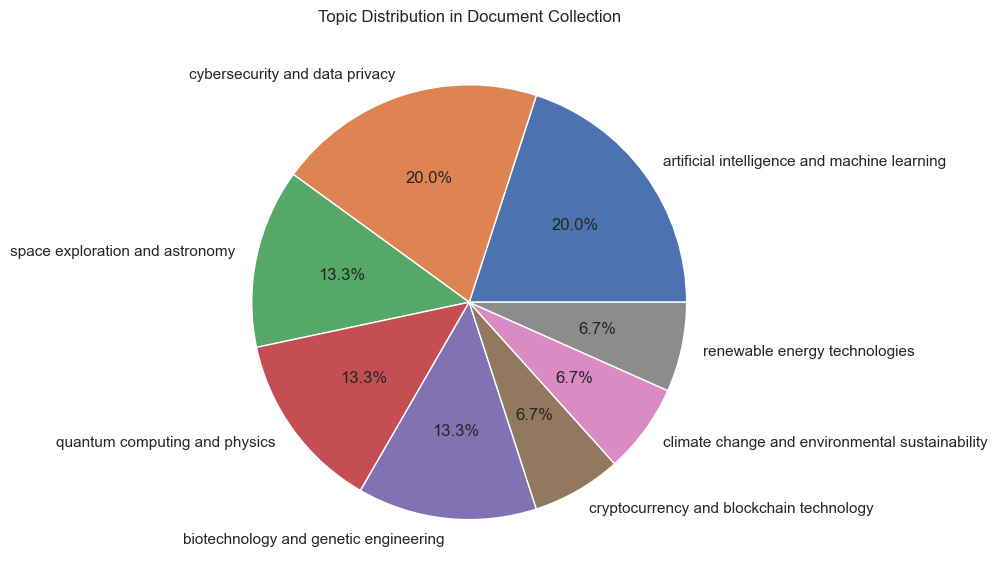


Number of documents with no additional topics: 4


,document_id,text,main_topic
0,0,This text discusses cryptocurrency and blockch...,cryptocurrency and blockchain technology
10,10,This text discusses artificial intelligence an...,artificial intelligence and machine learning
12,12,This text discusses cybersecurity and data pri...,cybersecurity and data privacy


In [24]:
# Topic distribution in full document collection
print("Topic Distribution in Document Collection:")
topic_dist = documents_df['main_topic'].value_counts()
display(topic_dist)

# Create a pie chart of topics
plt.figure(figsize=(10, 6))
plt.pie(topic_dist, labels=topic_dist.index, autopct='%1.1f%%')
plt.title('Topic Distribution in Document Collection')
plt.tight_layout()
plt.show()

# Check which documents don't contain any additional topics
docs_no_additional = documents_df[documents_df['additional_topics'].apply(lambda x: len(x) == 0)]
print(f"\nNumber of documents with no additional topics: {len(docs_no_additional)}")
display(docs_no_additional[['document_id', 'text', 'main_topic']].head(3))

# RAG

In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

model_id = "CohereLabs/c4ai-command-r-v01"
#model_id = "CohereLabs/c4ai-command-r-v01-4bit"
#model = AutoModelForCausalLM.from_pretrained(model_id)
c4ai_tokenizer = AutoTokenizer.from_pretrained(model_id)

# define conversation input:
conversation = [
    {"role": "user", "content": query}
]
truncated = results_df[["main_topic","text"]]
truncated.rename(columns={"main_topic": "title"}, inplace=True)
truncated

/var/folders/fp/y06qn5j51zn8mc1wjdjd82vh0000gn/T/ipykernel_2643/679881178.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truncated.rename(columns={"main_topic": "title"}, inplace=True)


,title,text
0,quantum computing and physics,This text discusses quantum computing and phys...
1,quantum computing and physics,This text discusses quantum computing and phys...
2,artificial intelligence and machine learning,This text discusses artificial intelligence an...


In [26]:
docs = truncated.to_dict(orient="records")
docs


[{'title': np.str_('quantum computing and physics'),
  'text': 'This text discusses quantum computing and physics with connections to cryptocurrency and blockchain technology and space exploration and astronomy. This subject has gained considerable attention in recent years.'},
 {'title': np.str_('quantum computing and physics'),
  'text': 'This text discusses quantum computing and physics with connections to renewable energy technologies and biotechnology and genetic engineering. There are still many unanswered questions in this domain. Recent advances have accelerated progress significantly. There are still many unanswered questions in this domain.'},
 {'title': np.str_('artificial intelligence and machine learning'),
  'text': 'This text discusses artificial intelligence and machine learning with connections to cybersecurity and data privacy and quantum computing and physics. The latest research in this field shows promising results. Interdisciplinary approaches are proving valuable

In [27]:
# render the tool use prompt as a string:
grounded_generation_prompt = c4ai_tokenizer.apply_grounded_generation_template(
    conversation,
    documents=docs,
    citation_mode="accurate", # or "fast"
    tokenize=False,
    add_generation_prompt=True,
)

print(grounded_generation_prompt)

<BOS_TOKEN><|START_OF_TURN_TOKEN|><|SYSTEM_TOKEN|># Safety Preamble
The instructions in this section override those in the task description and style guide sections. Don't answer questions that are harmful or immoral.

# System Preamble
## Basic Rules
You are a powerful conversational AI trained by Cohere to help people. You are augmented by a number of tools, and your job is to use and consume the output of these tools to best help the user. You will see a conversation history between yourself and a user, ending with an utterance from the user. You will then see a specific instruction instructing you what kind of response to generate. When you answer the user's requests, you cite your sources in your answers, according to those instructions.

# User Preamble
## Task and Context
You help people answer their questions and other requests interactively. You will be asked a very wide array of requests on all kinds of topics. You will be equipped with a wide range of search engines or simil

# Important to note, that i'm removing all documents and having prompt generation reindex them from 0...N

In [46]:
docs[0]

{'title': np.str_('quantum computing and physics'),
 'text': 'This text discusses quantum computing and physics with connections to cryptocurrency and blockchain technology and space exploration and astronomy. This subject has gained considerable attention in recent years.'}

In [35]:
from dotenv import load_dotenv
import os

load_dotenv()

key = os.getenv("OPENAI_API_KEY")
org = os.getenv("OPENAI_ORGANIZATION")

print(f"Key: {key[0:16]}")

from openai import OpenAI
client = OpenAI(api_key=key, organization=org)


print("Query: " + query)
response = client.responses.create(
    model="gpt-4.1-mini",
    input=grounded_generation_prompt
)
print(response.output_text)

Key: sk-proj-etnoLb9k
Query: What space can you do quantum computing in?
Relevant Documents: 0  
Cited Documents: 0  
Answer:  
Quantum computing can be done in various contexts related to physics, including areas connected to space exploration and astronomy. Quantum computers operate using quantum mechanics principles, which are applicable in analyzing complex physical phenomena often found in space-related research and other scientific fields. Essentially, the "space" where quantum computing is utilized spans both physical research environments on Earth and conceptual or exploratory fields such as space science.

Grounded answer:  
Quantum computing operates within the realm of quantum physics and has applications that extend into fields related to space exploration and astronomy. This means quantum computing is done in physical and conceptual spaces that involve studying and utilizing quantum mechanical effects, often in connection with analyzing data and phenomena from space-relate